<a href="https://colab.research.google.com/github/hwizard-wph/NAS/blob/main/Evolution_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
%tensorflow_version 1.x
!curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord
!git clone https://github.com/google-research/nasbench
!pip install ./nasbench
from nasbench import api
nasbench = api.NASBench('nasbench_full.tfrecord')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1989M  100 1989M    0     0   149M      0  0:00:13  0:00:13 --:--:--  168M
fatal: destination path 'nasbench' already exists and is not an empty directory.
Processing ./nasbench
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for nasbench: filename=nasbench-1.0-py3-none-any.whl size=46788 sha256=fb38ab1953cfd4a4290d501e966fc6dcc28ecce464ba49730f5685750d711079
  Stored in directory: /tmp/pip-ephem-wheel-cache-gdajq2ob/wheels/64/e0/f5/7eabfceccbb11fce1ab5888a8d31f59fcb43f

Loading dataset from file... This may take a few minutes...
Loaded dataset in 280 seconds


In [61]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2
OP_SPOTS = NUM_VERTICES - 2 
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1] 

In [62]:
def random_spec():
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec


In [63]:
def mutate_spec(old_spec):
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix)
    new_ops = copy.deepcopy(old_spec.original_ops)
    opt = random.randint(0, 1)
    if opt == 0:
      ind = random.randint(1, NUM_VERTICES - 2)
      available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
      new_ops[ind] = random.choice(available)
    else :
      while True:
        ones = []
        zeros = []
        src = random.randint(0, NUM_VERTICES - 2)
        for dst in range(src + 1, NUM_VERTICES - 1):
          if new_matrix[src][dst] == 0 :
            zeros.append(dst)
          else :
            ones.append(dst)
        if zeros and ones :
          one = random.choice(zeros)
          zero = random.choice(ones)
          new_matrix[src][one] = 1
          new_matrix[src][zero] = 0
          break
    new_spec = api.ModelSpec(new_matrix, new_ops)
    if nasbench.is_valid(new_spec):
      return new_spec

In [74]:
def run_evolution_search(cycles = 5000, population_size = 50, tournament_size = 10):
  nasbench.reset_budget_counters()
  population = []
  best_vali = [0.0]
  best_test = [0.0]
  for _ in range(population_size):
    spec = random_spec()
    data = nasbench.query(spec)
    population.append((data['validation_accuracy'], spec))
    if data['validation_accuracy'] > best_vali[-1]:
      best_vali.append(data['validation_accuracy'])
      best_test.append(data['test_accuracy'])
    else :
      best_vali.append(best_vali[-1])
      best_test.append(best_test[-1])
  while len(best_vali) < cycles:
    sample = []
    while len(sample) < tournament_size:
      candidate = random.choice(population)
      sample.append(candidate)
    parent = max(sample, key = lambda i:i[0])
    child_spec = mutate_spec(parent[1])
    child_data = nasbench.query(child_spec)
    child = (child_data['validation_accuracy'], child_spec)
    if child_data['validation_accuracy'] > best_vali[-1]:
      best_vali.append(child_data['validation_accuracy'])
      best_test.append(child_data['test_accuracy'])
    else :
      best_vali.append(best_vali[-1])
      best_test.append(best_test[-1])
    population.append(child)
    population.pop(0)
  
  return best_vali, best_test


Text(0.5, 0, 'model')

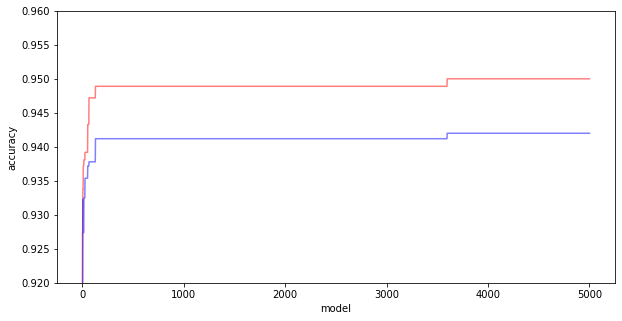

In [79]:
res_vali, res_test = run_evolution_search()
p = [i + 1 for i in range(5000)]
plt.figure(figsize=(10, 5))
plt.plot(p, res_vali, label='vali', color='red', alpha=0.5)
plt.plot(p, res_test, label='test', color='blue', alpha=0.5)
plt.ylim(0.92, 0.96)
plt.ylabel('accuracy')
plt.xlabel('model')